# Libraries used to get pretrained convnxt

In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms , models
from implemented_functions_to_use.helper_functions import set_seeds
from PIL import Image
import os

c:\Users\YOGA\.conda\envs\TF1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Testing which device used to train (CPU or GPU) 

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device
torch.version

<module 'torch.version' from 'c:\\Users\\YOGA\\.conda\\envs\\TF1\\lib\\site-packages\\torch\\version.py'>

## Save parameters as class

In [4]:
# Configure Model Parameters
class PARAM:
    EPOCHS = 10
    BATCH_SIZE = 32
    P = 0.5 #probability for Data Augmentation
    TF_SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_MEAN = [0.456]     #for Data Augmentation
    IMAGE_STD_DEVIATION = [0.224]     #for Data Augmentation
    PROB = 0.5   
    WEIGHT_DECAY = 0.01

# get pretraind model with his weight from torch

In [5]:
# Get pretrained weights for COnvNext-Base
model_convnext_weights = torchvision.models.ConvNeXt_Base_Weights.DEFAULT 

# create a COnvNext model with pretrained weights
model_convnext = torchvision.models.convnext_base(weights=model_convnext_weights).to(device)

# Disable Gradientdeit_tiny_patch16_224(weights=model_weights).to(device)
for parameter in model_convnext.parameters():
    parameter.requires_grad = False
    
# Define the classifier head 
class_names = ['Astrocitoma T1','Meningioma T1','Neurocitoma T1','Papiloma T1','Schwannoma T1','NORMAL T1']

set_seeds()
model_convnext.classifier[2] = nn.Linear(in_features=1024, out_features=len(class_names)).to(device)

for parameter in model_convnext.classifier.parameters():
    parameter.requires_grad = True

In [6]:
from torchinfo import summary

summary(model=model_convnext, 
        input_size=(PARAM.BATCH_SIZE, PARAM.CHANNELS, PARAM.HEIGHT, PARAM.WIDTH), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ConvNeXt (ConvNeXt)                                     [32, 3, 224, 224]    [32, 6]              --                   Partial
├─Sequential (features)                                 [32, 3, 224, 224]    [32, 1024, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                         [32, 3, 224, 224]    [32, 128, 56, 56]    --                   False
│    │    └─Conv2d (0)                                  [32, 3, 224, 224]    [32, 128, 56, 56]    (6,272)              False
│    │    └─LayerNorm2d (1)                             [32, 128, 56, 56]    [32, 128, 56, 56]    (256)                False
│    └─Sequential (1)                                   [32, 128, 56, 56]    [32, 128, 56, 56]    --                   False
│    │    └─CNBlock (0)                                 [32, 128, 56, 56]    [32, 128, 56, 56]    (138,496)            

## Setup directory paths to train and test images

In [7]:
# Setup directory paths to train and test images
train_dir = './archive_for_multiple_classes/train'
test_dir = './archive_for_multiple_classes/val'

## DATA Augmentation 

In [9]:
# Get automatic transforms from pretrained COnvNext weights and add more
model_convnext_transforms = model_convnext_weights.transforms(mean=PARAM.IMAGE_MEAN, std=PARAM.IMAGE_STD_DEVIATION)

pre_train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=PARAM.PROB),            # Random horizontal flip
    transforms.RandomRotation(degrees=15),              # Random rotation
])

train_transform = transforms.Compose([
    model_convnext_transforms,
    pre_train_transform
])

val_transform = model_convnext_transforms

print(model_convnext_transforms)
print(pre_train_transform)
print(train_transform)

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.456]
    std=[0.224]
    interpolation=InterpolationMode.BILINEAR
)
Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
)
Compose(
    ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.456]
    std=[0.224]
    interpolation=InterpolationMode.BILINEAR
)
    Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
)
)


## TESTING TRANSFORMER (Data AUG)

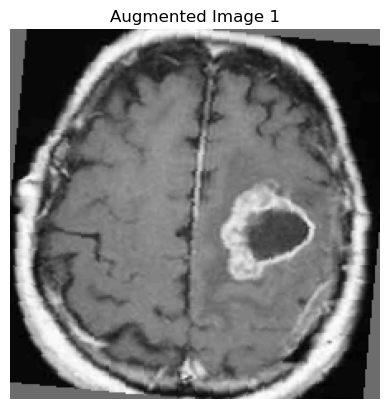

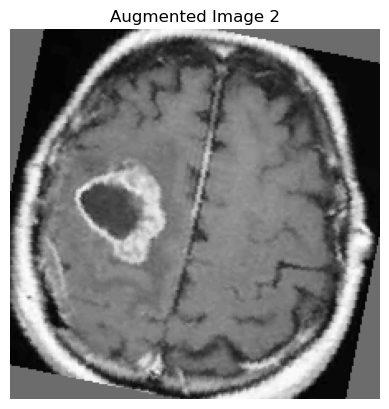

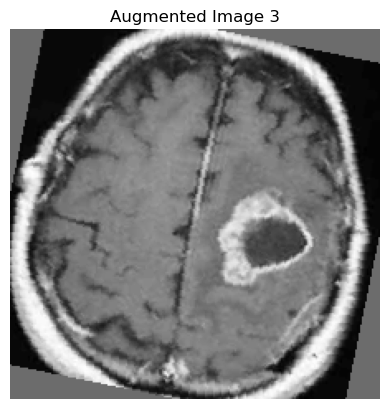

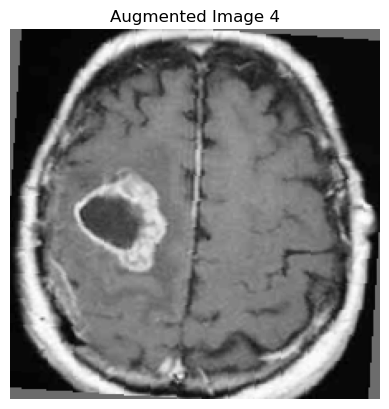

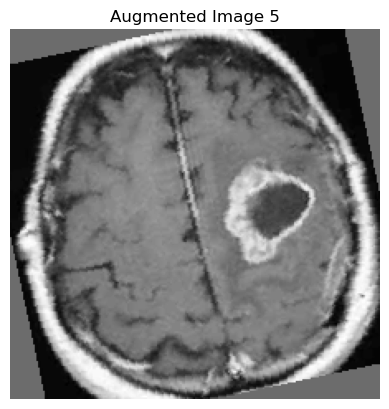

In [12]:
test_train_img = './archive_for_2_classes/train/yes/Y10.jpg'
image = Image.open(test_train_img)

def show_image(tensor, title="Test DA"):
    image = tensor.permute(1, 2, 0) # Convert from C x H x W to H x W x C for plotting
    plt.imshow(image, cmap="gray")
    plt.title(title)
    plt.axis('off')
    plt.show()

for i in range(5): 
    augmented_image = train_transform(image)
    show_image(augmented_image, title=f"Augmented Image {i+1}")

## Data augmenting Images in test folder

In [13]:
# Function to check if a folder has less than 200 images and augment if necessary
def augment_folder(folder_path: str, num_images_required: int = 200):
    current_images = os.listdir(folder_path)
    num_images = len(current_images)
    
    if num_images < num_images_required:
        print(f"Folder {folder_path} has {num_images} images. Augmenting...")
        

        augment_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),

            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
            transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.))
        ])


        while num_images < num_images_required:
            image_to_augment = random.choice(current_images)
            image_path = os.path.join(folder_path, image_to_augment)
            image = Image.open(image_path)
            
            # Apply transformations and save the augmented image
            augmented_image = augment_transform(image)
            new_image_name = f"aug_{num_images}.jpg"
            augmented_image.save(os.path.join(folder_path, new_image_name))
            num_images += 1
        print(f"Folder {folder_path} now has {num_images} images.")

# Function to augment images for all classes in a dataset folder
def augment_dataset_folder(root_dir: str, num_images_required: int = 200):
    for class_folder in os.listdir(root_dir):
        class_folder_path = os.path.join(root_dir, class_folder)
        if os.path.isdir(class_folder_path):
            augment_folder(class_folder_path, num_images_required)

## Turning images into DataLoaders using the create_dataloaders()

In [15]:
import os
import random

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [16]:
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    train_transform: train_transform,
    val_transform: val_transform,
    batch_size: int, 
    num_workers: int=NUM_WORKERS,
    augment: bool=True
):
        # Augmenting images of class directories which is less than 200 images 
    if augment:
        augment_dataset_folder(train_dir)
        augment_dataset_folder(test_dir,int(50))
    
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    test_data = datasets.ImageFolder(test_dir, transform=val_transform)
    
    # Get class names
    class_names = train_data.classes
    
    # Turn images into data loaders
    train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
    )
    test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
    )
    
    return train_dataloader, test_dataloader, class_names

In [17]:
# Setup dataloaders
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                                     test_dir=test_dir,
                                                                                     train_transform=train_transform,
                                                                                     val_transform=val_transform,
                                                                                     batch_size=PARAM.BATCH_SIZE) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


## Traing model and save results as dictionary

In [15]:
from implemented_functions_to_use.going_modular import engine
model_convnext.train()

for param in model_convnext.features.parameters():
    param.requires_grad = False
for param in model_convnext.classifier.parameters():
    param.requires_grad = True

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=[p for p in model_convnext.parameters() if p.requires_grad], 
                             lr=1e-3,
                             weight_decay=PARAM.WEIGHT_DECAY # To reduce the risk of overfitting
                            )
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained COnvNext feature extractor model
set_seeds()
convnext_model_results = engine.train(model=model_convnext,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=PARAM.EPOCHS,
                                      device=device)


 10%|█         | 1/10 [28:55<4:20:20, 1735.61s/it]

Epoch: 1 | train_loss: 1.4479 | train_acc: 0.4675 | test_loss: 1.2785 | test_acc: 0.5990


 20%|██        | 2/10 [57:11<3:48:18, 1712.30s/it]

Epoch: 2 | train_loss: 1.0818 | train_acc: 0.6752 | test_loss: 1.1444 | test_acc: 0.5875


 30%|███       | 3/10 [1:23:09<3:11:31, 1641.63s/it]

Epoch: 3 | train_loss: 0.9289 | train_acc: 0.7104 | test_loss: 1.0933 | test_acc: 0.6083


 40%|████      | 4/10 [1:49:28<2:41:42, 1617.17s/it]

Epoch: 4 | train_loss: 0.8434 | train_acc: 0.7699 | test_loss: 1.0528 | test_acc: 0.5948


 50%|█████     | 5/10 [2:15:44<2:13:30, 1602.14s/it]

Epoch: 5 | train_loss: 0.7935 | train_acc: 0.7758 | test_loss: 1.0051 | test_acc: 0.6177


 60%|██████    | 6/10 [2:41:55<1:46:06, 1591.52s/it]

Epoch: 6 | train_loss: 0.7617 | train_acc: 0.7777 | test_loss: 0.9851 | test_acc: 0.5990


 70%|███████   | 7/10 [3:08:10<1:19:18, 1586.12s/it]

Epoch: 7 | train_loss: 0.7462 | train_acc: 0.7817 | test_loss: 0.9604 | test_acc: 0.6427


 80%|████████  | 8/10 [3:34:23<52:44, 1582.07s/it]  

Epoch: 8 | train_loss: 0.7181 | train_acc: 0.8102 | test_loss: 0.9414 | test_acc: 0.6354


 90%|█████████ | 9/10 [4:00:40<26:20, 1580.49s/it]

Epoch: 9 | train_loss: 0.7067 | train_acc: 0.8007 | test_loss: 0.9556 | test_acc: 0.6417
No improvement for 1 epoch(s).


100%|██████████| 10/10 [4:27:01<00:00, 1602.11s/it]

Epoch: 10 | train_loss: 0.6870 | train_acc: 0.8170 | test_loss: 0.9440 | test_acc: 0.6510
No improvement for 2 epoch(s).


## Save model results as file

In [16]:
import pickle

# Saving the model
with open('convnext_model_results.pkl', 'wb') as file:
    pickle.dump(convnext_model_results, file)

print("Model saved successfully!")


Model saved successfully!


## Save model  as file

In [17]:
import pickle

# Saving the model
with open('convnext_model.pkl', 'wb') as file:
    pickle.dump(model_convnext, file)

print("Model saved successfully!")


Model saved successfully!


# Load model as file

In [19]:
import pickle
# Loading the model
with open('convnext_model.pkl', 'rb') as file:
    model_convnext = pickle.load(file)

print("Loaded model:", model_convnext)


Loaded model: ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate=none)
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          

In [1]:
import pickle
# Loading the model results
# with open('convnext_model_results.pkl', 'rb') as file:
with open('C:/Users/YOGA/Desktop/DM IMGs/convnext_model_results.pkl', 'rb') as file:
    convnext_model_results = pickle.load(file)

print("Loaded model:", convnext_model_results)


Loaded model: {'train_loss': [1.4498873978853226, 1.0816229835152626, 0.930680376291275, 0.8483565002679825, 0.8006153345108032, 0.7566607028245926, 0.7423104509711266, 0.7218206688761711, 0.7027015209197998, 0.6922539517283439, 0.6781111232936382, 0.6710957616567612, 0.6899733066558837, 0.6690964221954345, 0.6574901238083839, 0.6494386456906796, 0.6460205912590027, 0.6313539899885654, 0.6333255499601365, 0.6273820452392102, 0.6177411273121833, 0.6254275619983674, 0.6373542085289955, 0.6133615925908089, 0.6220774471759796, 0.612741781771183, 0.6042842552065849, 0.59891804382205], 'train_acc': [0.4479375, 0.6604062500000001, 0.7143125, 0.75575, 0.7697812500000001, 0.7766875, 0.79065625, 0.795125, 0.79153125, 0.8224375, 0.81375, 0.8100625000000001, 0.80859375, 0.8210000000000001, 0.8314999999999999, 0.8324999999999999, 0.8196562500000001, 0.8249062500000001, 0.82390625, 0.82971875, 0.8352812500000001, 0.8401875000000001, 0.8194375, 0.84375, 0.8236874999999999, 0.82825, 0.84109375, 0.8378

In [5]:
# print model training and testing accuarcy 
print('Train accuracy:',convnext_model_results["train_acc"][-1],'. Test accuracy:', convnext_model_results["test_acc"][-1])

Train accuracy: 0.83784375 . Test accuracy: 0.6572916666666667


c:\Users\YOGA\.conda\envs\TF1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


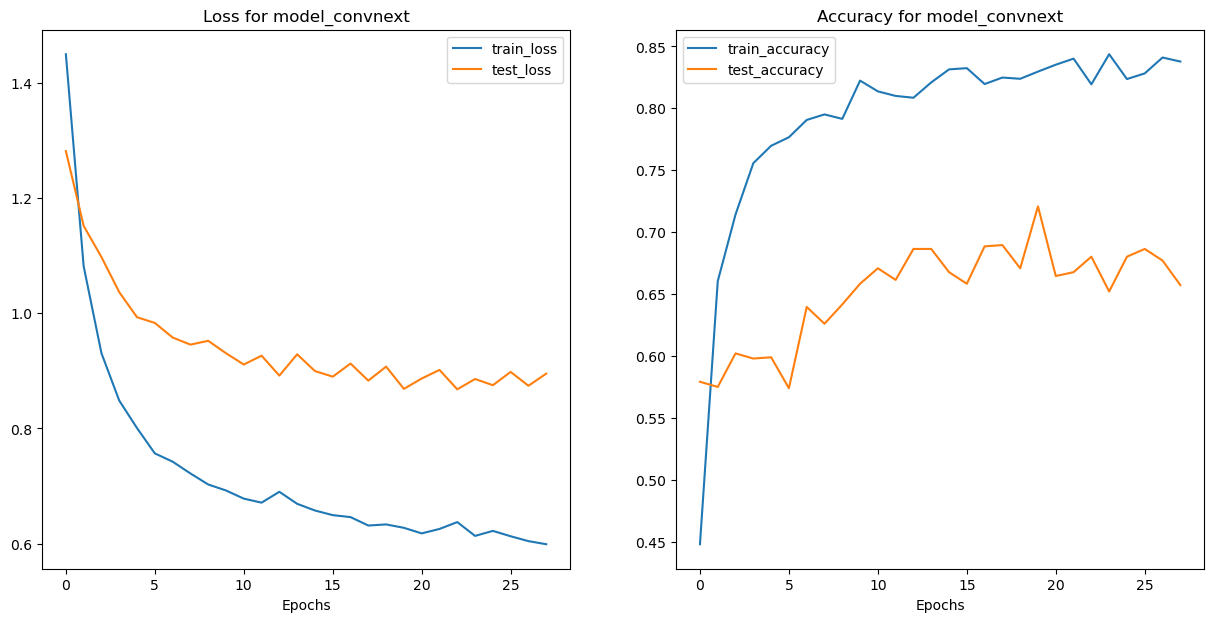

In [2]:
# Plot the loss curves
from implemented_functions_to_use.helper_functions import plot_loss_curves,plot_roc_auc,plot_confusion_matrix

plot_loss_curves('model_convnext',convnext_model_results) 


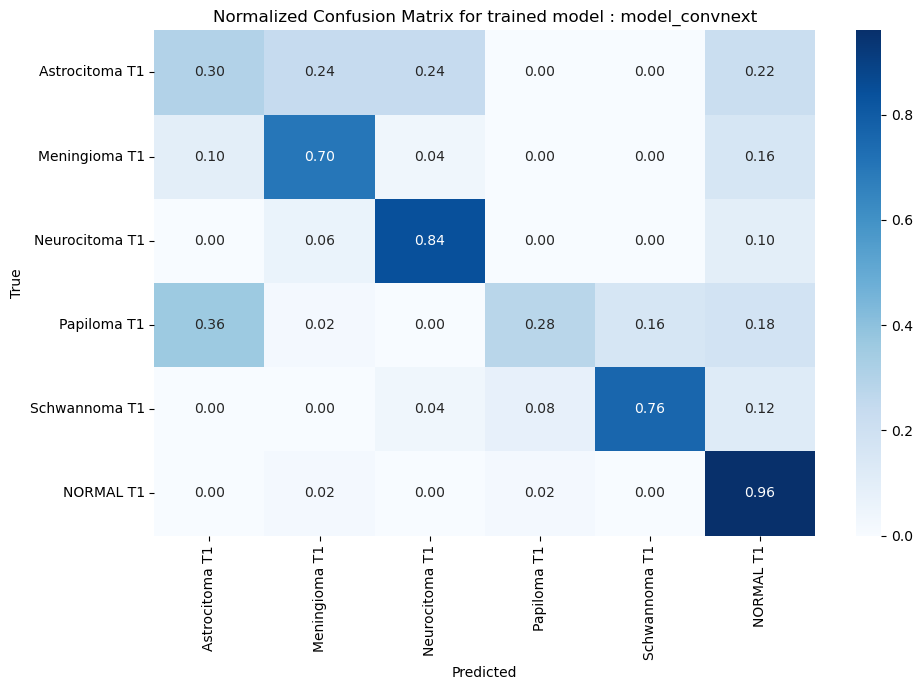

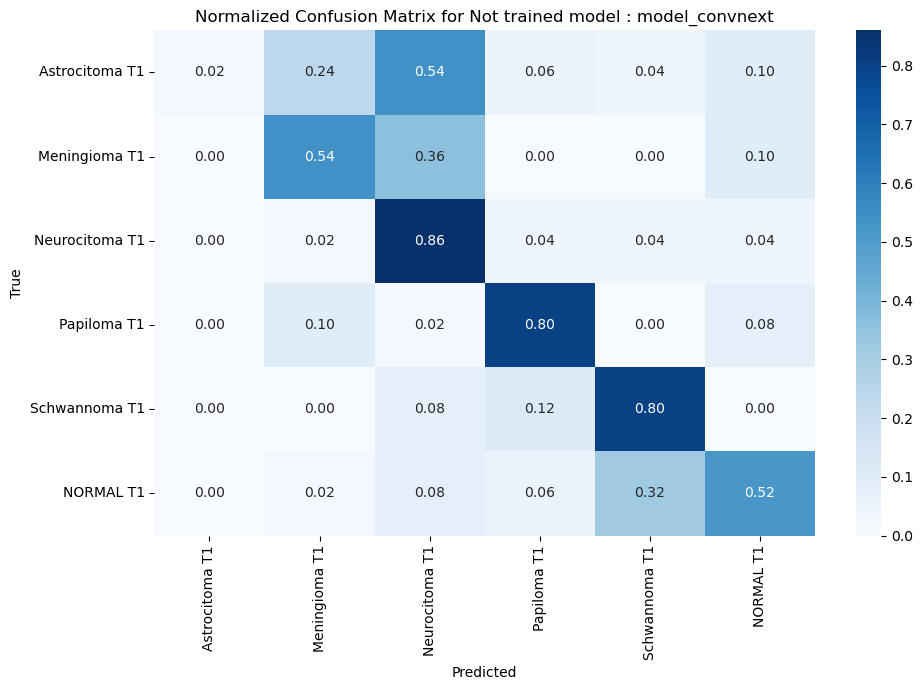

In [3]:

class_names = ['Astrocitoma T1','Meningioma T1','Neurocitoma T1','Papiloma T1','Schwannoma T1','NORMAL T1']
plot_confusion_matrix('model_convnext',convnext_model_results,class_names,True) # plot_confusion_matrix(model,results, class_names,trained):
plot_confusion_matrix('model_convnext',convnext_model_results,class_names,False)


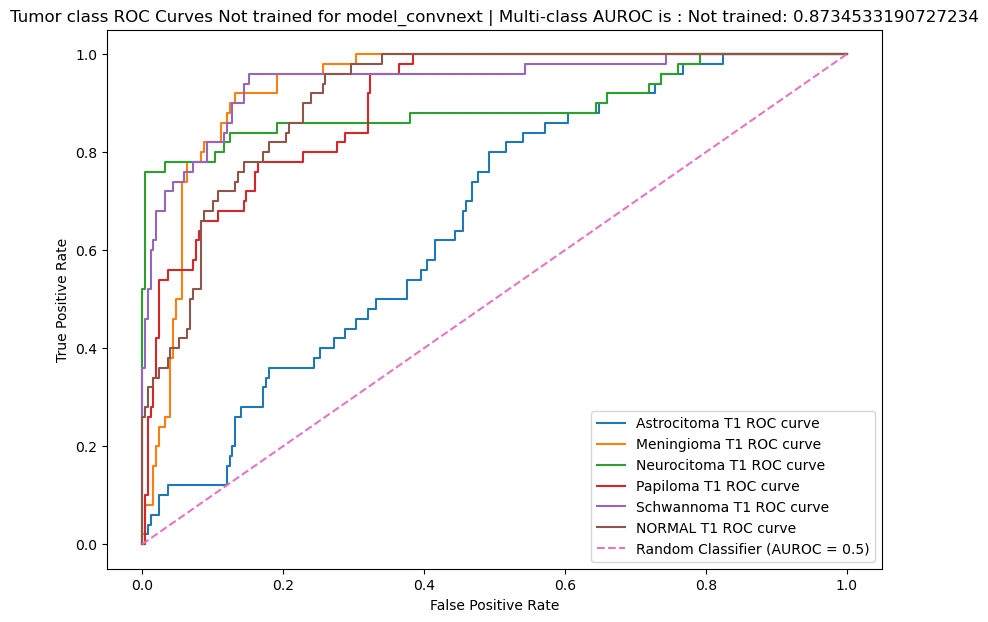

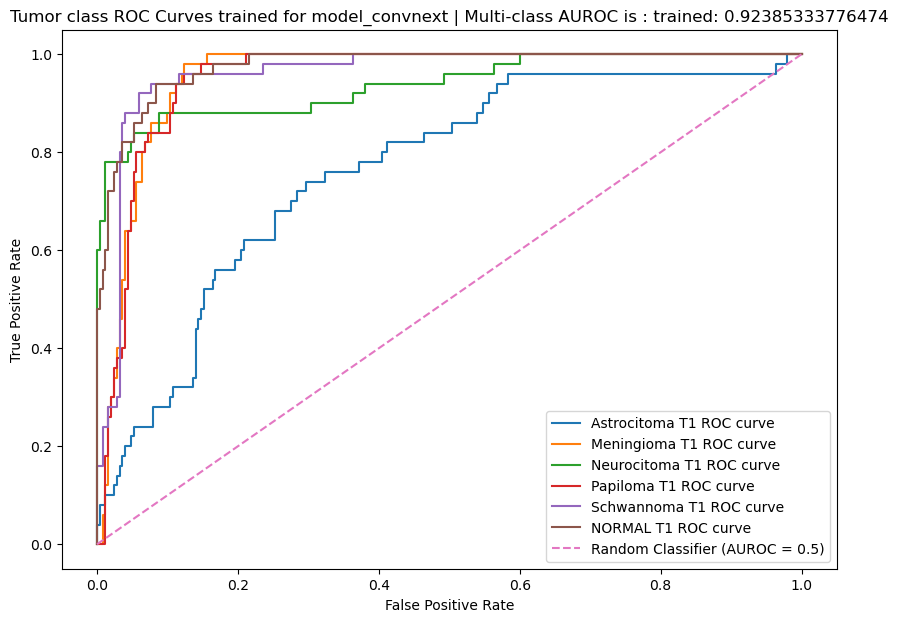

In [4]:
plot_roc_auc('model_convnext',convnext_model_results,len(class_names),class_names,False)
plot_roc_auc('model_convnext',convnext_model_results,len(class_names),class_names,True)

# Making some Predictions:

### Predict all images within predict folder

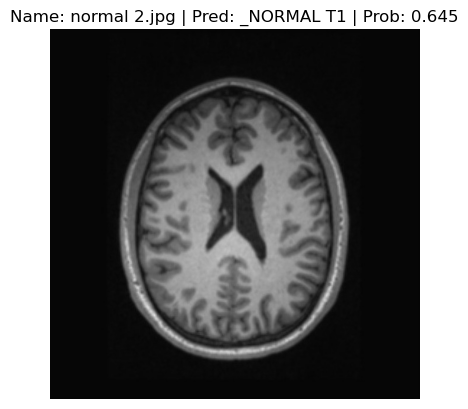

In [24]:
from implemented_functions_to_use.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "./predict/normal 2.jpg"

# Predict on custom image
pred_and_plot_image(model=model_convnext,
                    image_path=custom_image_path,
                    class_names=class_names)

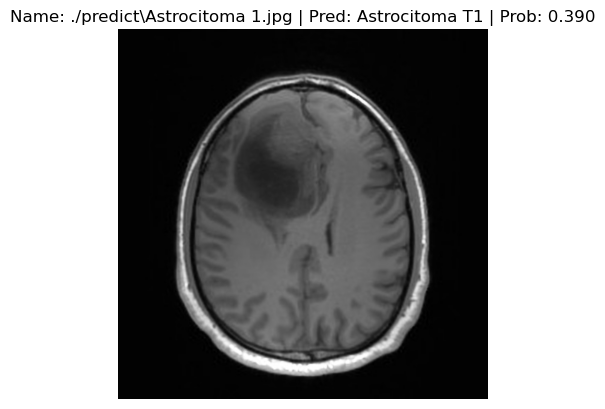

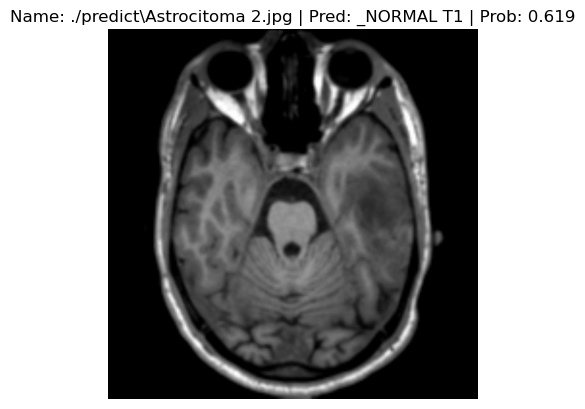

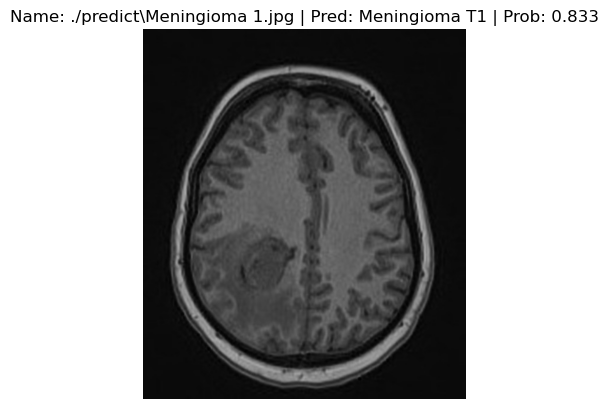

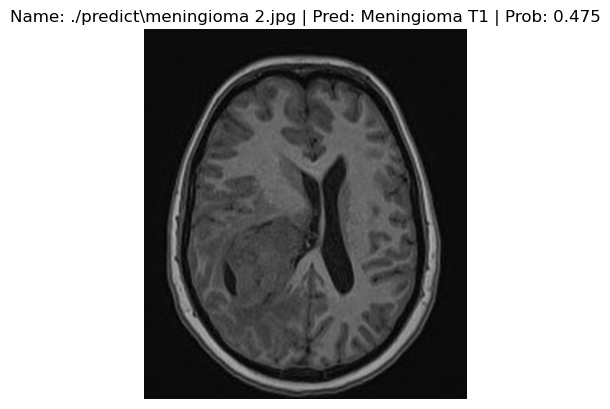

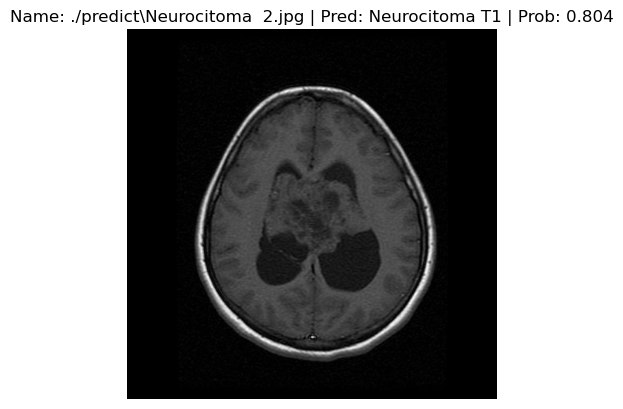

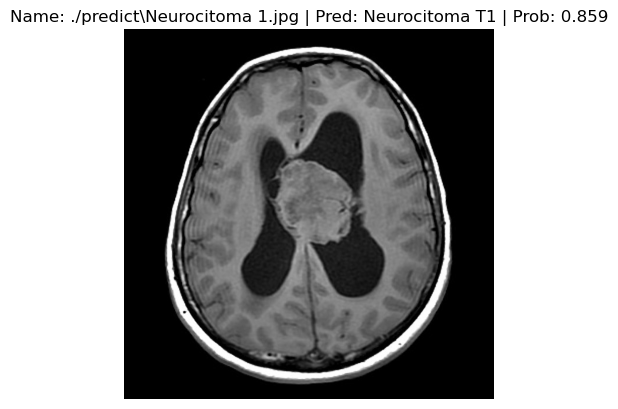

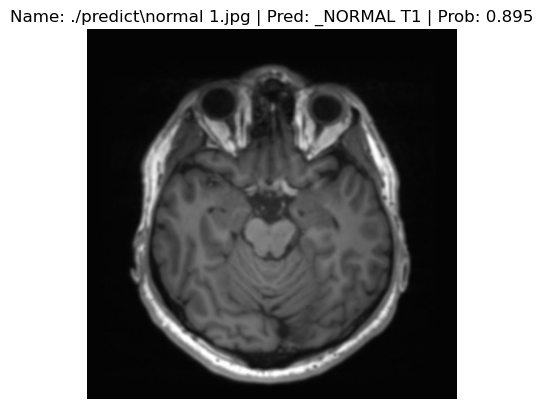

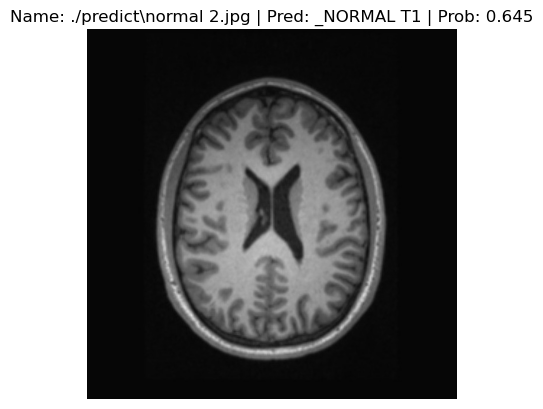

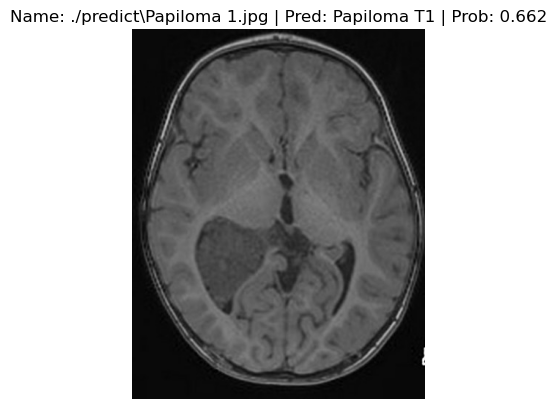

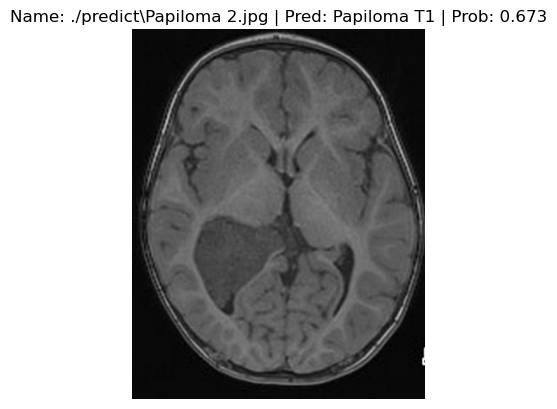

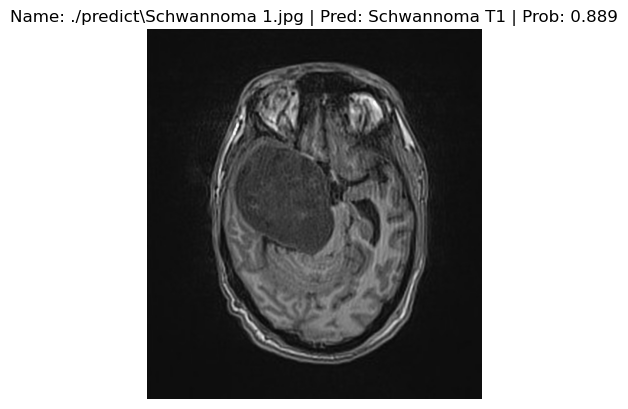

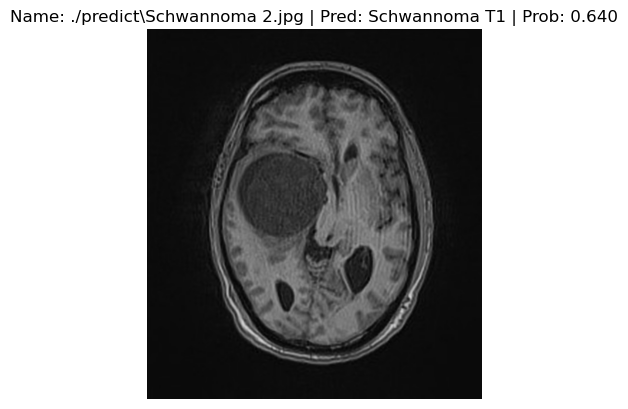

In [25]:
import glob

predict_path = './predict/*.jpg'
for image_path in glob.iglob(predict_path):
    pred_and_plot_image(model=model_convnext,
                    image_path=image_path,
                    class_names=class_names)
    


In [ ]:
# import requests

# # Import function to make predictions on images and plot them 
# from implemented_functions_to_use.going_modular.predictions import pred_and_plot_image

# # Setup custom image path
# custom_image_path = "./predict/normal 2.jpg"

# # Predict on custom image
# pred_and_plot_image(model=loaded_model,
#                     image_path=custom_image_path,
#                     class_names=class_names)

In [ ]:
# import glob
# predict_path = './predict/*.jpg'
# for image_path in glob.iglob(predict_path):
#     pred_and_plot_image(model=loaded_model,
#                     image_path=image_path,
#                     class_names=class_names)
    